## Summary

---

## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1
%env TF_FORCE_UNIFIED_MEMORY=1
%env XLA_PYTHON_CLIENT_MEM_FRACTION=4.0

env: CUDA_VISIBLE_DEVICES=1
env: TF_FORCE_UNIFIED_MEMORY=1
env: XLA_PYTHON_CLIENT_MEM_FRACTION=4.0


In [2]:
import concurrent.futures
import contextlib
import itertools
import json
import os
import sys
import tempfile
import urllib.request
from datetime import datetime
from pathlib import Path

import dotenv
import elaspic2 as el2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import torch
from elaspic2.plugins.msa import analyze_msa
from elaspic2.plugins.rosetta_ddg import RosettaDDG
from kmbio import PDB
from kmtools import structure_tools
from tqdm.auto import tqdm

## Parameters

In [3]:
NOTEBOOK_DIR = Path("40_cagi6_mapk3_submission").resolve()
NOTEBOOK_DIR.mkdir(exist_ok=True)

NOTEBOOK_DIR

PosixPath('/home/kimlab5/strokach/workspace/elaspic/elaspic2-cagi6/notebooks/40_cagi6_mapk3_submission')

In [4]:
src_dir = str(NOTEBOOK_DIR.parents[1].joinpath("src"))
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

import helpers

In [5]:
UNIPROT_ID = "P27361"

UNIPROT_ID

'P27361'

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [7]:
version = datetime.now().isoformat(timespec="hours")

version

'2021-10-01T21'

## Download data

In [8]:
def download(url, filename):
    urllib.request.urlretrieve(url, filename)

In [9]:
def load_sequence(sequence_file):
    with sequence_file.open("rt") as fin:
        data = fin.read()
    chunks = []
    for line in data.split("\n"):
        if line.startswith(">"):
            continue
        chunks.append(line.strip())
    return "".join(chunks)

In [10]:
if not NOTEBOOK_DIR.joinpath("validation.py").is_file():
    import synapseclient
    import synapseutils

    dotenv.load_dotenv("../.env")
    syn = synapseclient.Synapse()
    syn.login(os.environ["SYNAPSE_USERNAME"], os.environ["SYNAPSE_PASSWORD"])
    _ = synapseutils.syncFromSynapse(syn, "syn26019572", path=NOTEBOOK_DIR)

In [11]:
sequence_file = NOTEBOOK_DIR.joinpath(f"{UNIPROT_ID}.fasta")

if not sequence_file.is_file():
    download(f"https://www.uniprot.org/uniprot/{UNIPROT_ID}.fasta", sequence_file)

sequence = load_sequence(sequence_file)

In [12]:
structure_file = NOTEBOOK_DIR.joinpath(f"{UNIPROT_ID}.pdb")

if not structure_file.is_file():
    download(f"https://alphafold.ebi.ac.uk/files/AF-{UNIPROT_ID}-F1-model_v1.pdb", structure_file)

with structure_file.open("r") as fin:
    structure_blob = fin.read()

In [13]:
alignment_file = NOTEBOOK_DIR.joinpath(f"{UNIPROT_ID}.a3m.gz")

if not alignment_file.is_file():
    from elaspic2.plugins.alphafold import mmseqs2

    dotenv.load_dotenv("../.env")
    with mmseqs2.api_gateway(mmseqs2.MMSEQS2_HOST_URL) as gateway:
        alignment = mmseqs2.run_mmseqs2(sequence, gateway=gateway)
        assert alignment[1] == f"{sequence}\n"
        alignment_df = pd.DataFrame({"alignment": alignment})
        pq.write_table(pa.Table.from_pandas(alignment_df, preserve_index=False), alignment_file)

alignment = pq.read_table(alignment_file).to_pandas()["alignment"].values.tolist()

## Load data

In [14]:
def mutation_matches_sequence(mutation, sequence):
    wt, pos, mut = mutation[0], mutation[1:-1], mutation[-1]
    pos = int(pos)
    return sequence[pos - 1] == wt

In [15]:
def sequence_matches_structure(sequence, structure_blob):
    with tempfile.NamedTemporaryFile(suffix=".pdb") as tmp_file:
        with open(tmp_file.name, "wt") as fout:
            fout.write(structure_blob)
        structure = PDB.load(tmp_file.name)

    chain_sequence = structure_tools.get_chain_sequence(
        structure[0]["A"], if_unknown="replace", unknown_residue_marker=""
    )
    return sequence == chain_sequence

In [16]:
result_template_df = pd.read_csv(NOTEBOOK_DIR.joinpath("mapk3_predictions.tsv"), sep="\t")

result_template_df.head(2)

,MAPK3-variant,DDG-NotPO4,Standard-Deviation-DDG-NotPO4,DDG-PO4,Standard-Deviation-DDG-PO4,Ratio-kcat/Km,Standard-Deviation-Ratio-kcat/Km,Comment
0,p.I73M,*,*,*,*,*,*,*
1,p.Q79H,*,*,*,*,*,*,*


In [17]:
result_df = result_template_df.copy()
result_df["mut"] = result_df["MAPK3-variant"].str[2:]

In [18]:
assert all([mutation_matches_sequence(mut, sequence) for mut in result_df["mut"]])

In [19]:
assert sequence_matches_structure(sequence, structure_blob)

In [20]:
assert alignment[1] == f"{sequence}\n"

## Run Rosetta

In [21]:
rosetta_ddg_data = RosettaDDG.build(
    structure_file,
    protocol="cartesian_ddg",
    energy_function="beta_nov16_cart",
    interface=0,
)

In [22]:
def rosetta_ddg_worker(mut, data):
    results = RosettaDDG.analyze_mutation(f"A_{mut}", data)
    results = {"mut": mut} | {f"rosetta_{key}": value for key, value in results.items()}
    return results

In [23]:
rosetta_results_file = NOTEBOOK_DIR.joinpath("rosetta-results.parquet")

if rosetta_results_file.is_file():
    rosetta_results_df = pq.read_table(rosetta_results_file).to_pandas()
else:
    with concurrent.futures.ThreadPoolExecutor(len(result_df)) as pool:
        rosetta_results = list(
            tqdm(
                pool.map(
                    rosetta_ddg_worker,
                    result_df["mut"].values.tolist(),
                    itertools.repeat(rosetta_ddg_data),
                ),
                total=len(result_df),
            )
        )
    rosetta_results_df = pd.DataFrame(rosetta_results)
    pq.write_table(
        pa.Table.from_pandas(rosetta_results_df, preserve_index=False), rosetta_results_file
    )

In [24]:
display(rosetta_results_df.head(2))
print(len(rosetta_results_df))

,mut,rosetta_cart_bonded_wt,rosetta_rama_prepro_wt,rosetta_ref_wt,rosetta_hxl_tors_wt,rosetta_p_aa_pp_wt,rosetta_fa_dun_semi_wt,rosetta_fa_dun_rot_wt,rosetta_fa_dun_dev_wt,rosetta_omega_wt,...,rosetta_lk_ball_bridge_change,rosetta_lk_ball_iso_change,rosetta_lk_ball_change,rosetta_fa_intra_sol_xover4_change,rosetta_fa_intra_rep_xover4_change,rosetta_fa_intra_atr_xover4_change,rosetta_fa_sol_change,rosetta_fa_rep_change,rosetta_fa_atr_change,rosetta_dg_change
0,I73M,468.339667,152.896667,-107.474,155.009000,-41.487333,358.597667,199.903333,173.102333,291.502667,...,0.007333,0.003667,0.159667,0.137667,-0.158667,-0.092000,2.890000,-0.373000,-1.527667,1.366667
1,Q79H,470.089000,152.485667,-107.474,162.533667,-41.696333,360.979000,197.076333,194.329000,292.965667,...,-0.023000,-0.451333,-0.456667,0.186333,-0.065333,-0.089333,0.449333,1.257667,-1.289000,1.452667


12


## Run AlphaFold

In [25]:
def worker(mutation, data):
    try:
        results = AlphaFold.analyze_mutation(f"A_{mutation}", data)
    except Exception as error:
        print(f"{error!r}")
        return None
    else:
        results = {f"alphafold_core_{key}": value for key, value in results.items()}
        return results

In [26]:
alphafold_results_file = NOTEBOOK_DIR.joinpath("alphafold-results.parquet")

if alphafold_results_file.is_file():
    alphafold_results_df = pq.read_table(alphafold_results_file).to_pandas()
else:
    from elaspic2.plugins.alphafold import AlphaFold, AlphaFoldAnalyzeError, AlphaFoldBuildError
    from jax.lib import xla_bridge

    jax_device = xla_bridge.get_backend().platform
    print(f"Device: {jax_device}")

    AlphaFold.load_model(device=jax_device)
    data = AlphaFold.build(sequence, ligand_sequence=None, msa=alignment)

    result_list = []
    for mut in tqdm(result_df["mut"], leave=False):
        result = worker(mut, data)
        result_list.append({"mut": mut} | result)
    alphafold_results_df = pd.DataFrame(result_list)

    pq.write_table(
        pa.Table.from_pandas(alphafold_results_df, preserve_index=False), alphafold_results_file
    )

In [27]:
display(alphafold_results_df.head(2))
print(len(alphafold_results_df))

,mut,alphafold_core_scores_residue_plddt_wt,alphafold_core_scores_protein_plddt_wt,alphafold_core_scores_protein_max_predicted_aligned_error_wt,alphafold_core_scores_proten_ptm_wt,alphafold_core_features_residue_experimentally_resolved_wt,alphafold_core_features_residue_predicted_lddt_wt,alphafold_core_features_residue_msa_first_row_wt,alphafold_core_features_residue_single_wt,alphafold_core_features_residue_structure_module_wt,...,alphafold_core_features_residue_experimentally_resolved_mut,alphafold_core_features_residue_predicted_lddt_mut,alphafold_core_features_residue_msa_first_row_mut,alphafold_core_features_residue_single_mut,alphafold_core_features_residue_structure_module_mut,alphafold_core_features_protein_experimentally_resolved_mut,alphafold_core_features_protein_predicted_lddt_mut,alphafold_core_features_protein_msa_first_row_mut,alphafold_core_features_protein_single_mut,alphafold_core_features_protein_structure_module_mut
0,I73M,89.605976,84.518212,31.75,0.849999,"[3.6290748, 3.7973425, 4.2734876, 3.559348, 4....","[-10.512778, -11.93231, -9.935118, -9.103899, ...","[-2.8592641, 3.4308205, 14.783053, 5.0693607, ...","[60.97126, 55.834232, 1.5938658, -7.575698, -1...","[0.0015794635, 0.011161171, -0.0056965444, 0.0...",...,"[3.5453632, 3.7268736, 4.1792274, 3.458398, 4....","[-10.369872, -11.793799, -9.807745, -8.991145,...","[-1.1854149, 2.4412565, 13.099518, 5.5893917, ...","[54.19502, 53.576317, 6.718537, -12.898656, -1...","[0.0015215352, 0.010927603, -0.005702028, 0.00...","[2.784755, 2.9134758, 3.2904088, 2.779093, 3.3...","[-8.535637, -9.482369, -8.275576, -7.4080825, ...","[4.2533255, 4.472761, -0.6898077, 1.5236061, -...","[26.811329, 10.481789, 7.400012, 4.595044, 5.8...","[0.0011052352, 0.010742479, -0.005919944, 0.00..."
1,Q79H,84.960966,84.518212,31.75,0.849999,"[3.940667, 4.0633817, 4.4250245, 4.0075483, 4....","[-7.2024946, -8.241891, -7.25713, -6.562296, -...","[12.790734, 16.888803, -6.8924904, 4.88217, -2...","[56.02134, -35.143005, -67.70256, 20.18287, 19...","[0.0031776056, 0.010669984, -0.0059339087, 0.0...",...,"[4.253464, 4.3940325, 4.7798467, 4.2907968, 4....","[-7.1870084, -8.175636, -7.200021, -6.506134, ...","[13.19207, 14.478604, -7.066455, 6.3435163, -2...","[51.011642, -34.14663, -64.46977, 16.284336, 6...","[0.0030293465, 0.010777913, -0.005934259, 0.00...","[2.7799199, 2.9081771, 3.2842107, 2.7743576, 3...","[-8.5375595, -9.483548, -8.2759495, -7.408301,...","[4.228886, 4.4589715, -0.700582, 1.5512381, -6...","[26.7827, 10.457484, 7.4125285, 4.6370673, 5.8...","[0.0011114243, 0.010763805, -0.005919809, 0.00..."


12


## Run ProteinSolver

In [28]:
def worker(mutation, data):
    try:
        results = ProteinSolver.analyze_mutation(f"A_{mutation}", data)
    except Exception as error:
        print(f"{error!r}")
        return None
    else:
        results = {f"proteinsolver_core_{key}": value for key, value in results.items()}
        return results

In [29]:
proteinsolver_results_file = NOTEBOOK_DIR.joinpath("proteinsolver-results.parquet")

if proteinsolver_results_file.is_file():
    proteinsolver_results_df = pq.read_table(proteinsolver_results_file).to_pandas()
else:
    from elaspic2.plugins.proteinsolver import ProteinSolver

    ProteinSolver.load_model(device=device)

    data = ProteinSolver.build(structure_file, sequence, None, remove_hetatms=False)

    result_list = []
    for mut in tqdm(result_df["mut"], leave=False):
        result = worker(mut, data)
        result_list.append({"mut": mut} | result)
    proteinsolver_results_df = pd.DataFrame(result_list)

    pq.write_table(
        pa.Table.from_pandas(proteinsolver_results_df, preserve_index=False),
        proteinsolver_results_file,
    )

In [30]:
display(proteinsolver_results_df.head(2))
print(len(proteinsolver_results_df))

,mut,proteinsolver_core_score_wt,proteinsolver_core_score_mut,proteinsolver_core_features_residue_wt,proteinsolver_core_features_protein_wt,proteinsolver_core_features_residue_mut,proteinsolver_core_features_protein_mut
0,I73M,0.416913,0.011631,"[-3.84128999710083, 0.8013101816177368, 0.0243...","[-1.3879121541976929, 0.6547006964683533, 0.12...","[-3.6069047451019287, 0.22248061001300812, -0....","[-1.3863307237625122, 0.647650420665741, 0.120..."
1,Q79H,0.044277,0.028519,"[-0.13290949165821075, 0.675199568271637, -0.7...","[-1.3879121541976929, 0.6547006964683533, 0.12...","[-4.47153377532959, 0.4991134703159332, -0.200...","[-1.3995500802993774, 0.6538957357406616, 0.12..."


12


## Run ProtBert

In [31]:
def worker(mutation, data):
    try:
        results = ProtBert.analyze_mutation(f"A_{mutation}", data)
    except Exception as error:
        print(f"{error!r}")
        return None
    else:
        results = {f"protbert_core_{key}": value for key, value in results.items()}
        return results

In [32]:
protbert_results_file = NOTEBOOK_DIR.joinpath("protbert-results.parquet")

if protbert_results_file.is_file():
    protbert_results_df = pq.read_table(protbert_results_file).to_pandas()
else:
    from elaspic2.plugins.protbert import ProtBert

    ProtBert.load_model(device=device)
    data = ProtBert.build(sequence, ligand_sequence=None)

    result_list = []
    for mut in tqdm(result_df["mut"], leave=False):
        result = worker(mut, data)
        result_list.append({"mut": mut} | result)
    protbert_results_df = pd.DataFrame(result_list)

    pq.write_table(
        pa.Table.from_pandas(protbert_results_df, preserve_index=False), protbert_results_file
    )

In [33]:
display(protbert_results_df.head(2))
print(len(protbert_results_df))

,mut,protbert_core_score_wt,protbert_core_score_mut,protbert_core_features_residue_wt,protbert_core_features_protein_wt,protbert_core_features_residue_mut,protbert_core_features_protein_mut
0,I73M,0.978126,0.000716,"[0.13129837810993195, -0.03898658975958824, -0...","[0.07031252980232239, -0.013878961093723774, -...","[0.10953198373317719, -0.06380636990070343, -0...","[0.0704592913389206, -0.012903289869427681, -0..."
1,Q79H,0.991156,0.001122,"[0.1967078298330307, 0.04909868910908699, -0.0...","[0.07031252980232239, -0.013878961093723774, -...","[0.19389745593070984, 0.05682474002242088, -0....","[0.06953047960996628, -0.013008753769099712, -..."


12


## Run MSA

In [34]:
msa_results_file = NOTEBOOK_DIR.joinpath("msa-results.parquet")

if msa_results_file.is_file():
    msa_results_df = pq.read_table(msa_results_file).to_pandas()
else:
    from elaspic2.plugins.msa import analyze_msa

    msa_sequences = analyze_msa.alignment_to_sequences(alignment)
    assert sequence == msa_sequences[0]
    assert all([len(sequence) == len(seq) for seq in msa_sequences])

    msa_counts_mat = analyze_msa.sequences_to_counts(msa_sequences)
    msa_probas_mat = analyze_msa.counts_to_probas(msa_counts_mat)
    msa_length = len(msa_sequences)
    msa_proba_mean = np.mean(
        [msa_probas_mat[i, analyze_msa.AMINO_ACIDS.index(aa)] for i, aa in enumerate(sequence)]
    )
    msa_conservation_df = analyze_msa.run_convervation_script(msa_sequences)

    msa_results = []
    for mutation in result_df["mut"]:
        msa_result = analyze_msa.featurize_mutation(
            mutation,
            sequence=sequence,
            msa_counts_mat=msa_counts_mat,
            msa_probas_mat=msa_probas_mat,
            msa_conservation_df=msa_conservation_df,
            msa_length=msa_length,
            msa_proba_mean=msa_proba_mean,
        )
        msa_results.append(msa_result)
    msa_results_df = pd.DataFrame(msa_results)
    pq.write_table(pa.Table.from_pandas(msa_results_df, preserve_index=False), msa_results_file)

In [35]:
display(msa_results_df.head(2))
print(len(msa_results_df))

,mut,msa_count_wt,msa_count_mut,msa_count_total,msa_proba_wt,msa_proba_mut,msa_proba_total,msa_length,msa_proba,msa_H,msa_KL
0,I73M,6358.0,916.0,13201.0,-0.731935,-2.668454,-106.957204,19353,-1.302651,1.693647,1.044815
1,Q79H,1084.0,197.0,13357.0,-2.511957,-4.213025,-68.690187,19353,-1.302651,2.608015,0.335372


12


## Run `ELASPIC2`

### Initialize the `ELASPIC2` model



In [36]:
model = el2.ELASPIC2(device=device)

/home/strokach/envs/default-v46/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
Some weights of the model checkpoint at /home/kimlab5/strokach/workspace/elaspic/elaspic2/src/elaspic2/plugins/protbert/data/prot_bert_bfd were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
-

### Make predictions

In [37]:
protein_features = model.build(
    structure_file=structure_file,
    protein_sequence=sequence,
    ligand_sequence=None,
    remove_hetatms=True,
)

protein_features

ELASPIC2Data(is_interface=False, protbert_data=ProtBertData(sequence='MAAAAAQGGGGGEPRRTEGVGPGVPGEVEMVKGQPFDVGPRYTQLQYIGEGAYGMVSSAYDHVRKTRVAIKKISPFEHQTYCQRTLREIQILLRFRHENVIGIRDILRASTLEAMRDVYIVQDLMETDLYKLLKSQQLSNDHICYFLYQILRGLKYIHSANVLHRDLKPSNLLINTTCDLKICDFGLARIADPEHDHTGFLTEYVATRWYRAPEIMLNSKGYTKSIDIWSVGCILAEMLSNRPIFPGKHYLDQLNHILGILGSPSQEDLNCIINMKARNYLQSLPSKTKVAWAKLFPKSDSKALDLLDRMLTFNPNKRITVEEALAHPYLEQYYDPTDEPVAEEPFTFAMELDDLPKERLKELIFQETARFQPGVLEAP'), proteinsolver_data=Data(edge_attr=[19140, 2], edge_index=[2, 19140], x=[379]))

In [38]:
mutation_features = list(
    tqdm(
        (model.analyze_mutation(mut, protein_features) for mut in result_df["mut"]),
        total=len(result_df),
    )
)

  0%|          | 0/12 [00:00<?, ?it/s]

In [39]:
mutation_features = [
    {k: v for k, v in features.items() if "proteinsolver_core_features" not in k}
    for features in mutation_features
]

In [40]:
# In all cases, higher scores means less stable (same as ΔΔG)
result_df["protbert_score"] = [
    f["protbert_core_score_wt"] - f["protbert_core_score_mut"] for f in mutation_features
]
result_df["proteinsolver_score"] = [
    f["proteinsolver_core_score_wt"] - f["proteinsolver_core_score_mut"] for f in mutation_features
]
result_df["el2_score"] = model.predict_mutation_effect(mutation_features).tolist()

In [41]:
# In all cases, higher scores means less stable (same as ΔΔG)
result_df["protbert_ratio"] = [
    f["protbert_core_score_mut"] / f["protbert_core_score_wt"] for f in mutation_features
]
result_df["proteinsolver_ratio"] = [
    f["proteinsolver_core_score_mut"] / f["proteinsolver_core_score_wt"] for f in mutation_features
]
result_df["el2_ratio"] = (0.5 / model.predict_mutation_effect(mutation_features)).tolist()

## Run ELASPIC2 + AlphaFold

In [42]:
prediction_df = (
    proteinsolver_results_df
    #
    .merge(protbert_results_df, on=["mut"])
    .merge(rosetta_results_df, on=["mut"])
    .merge(msa_results_df, on=["mut"])
    .merge(alphafold_results_df, on=["mut"])
    .merge(result_df[["mut", "el2_score"]], on=["mut"])
)

prediction_df["aa_wt_onehot"] = (
    prediction_df["mut"].str[0].map(analyze_msa.RESIDUE_ENCODING_WT).apply(list)
)
prediction_df["aa_mut_onehot"] = (
    prediction_df["mut"].str[-1].map(analyze_msa.RESIDUE_ENCODING_MUT).apply(list)
)

for column in list(prediction_df):
    if not column.endswith("_mut"):
        continue

    column_wt = column.removesuffix("_mut") + "_wt"
    if column_wt not in prediction_df:
        print(column_wt)
        continue

    column_change = column.removesuffix("_mut") + "_change"
    prediction_df[column_change] = prediction_df[column_wt] - prediction_df[column]
    del prediction_df[column]

In [43]:
model_infos = [
    ("7f9826be", "optimized"),
    ("900500fe", "optimized"),
]

for unique_id, model_type in model_infos:
    scalar_features, vector_features = helpers.load_features(NOTEBOOK_DIR.parent, unique_id)
    features_to_exclude = helpers.load_features_to_exclude(
        NOTEBOOK_DIR.parent, unique_id, model_type
    )
    best_parameters = helpers.load_best_parameters(NOTEBOOK_DIR.parent, unique_id, model_type)
    models = helpers.load_best_models(NOTEBOOK_DIR.parent, unique_id, model_type)

    mask = ~prediction_df[scalar_features + vector_features].isnull().any(axis=1)

    X_ref = np.c_[
        prediction_df.loc[mask, scalar_features].values,
        np.hstack([np.vstack(prediction_df.loc[mask, col].values) for col in vector_features]),
    ]

    if features_to_exclude is not None:
        feature_mask = np.ones(X_ref.shape[1], dtype=bool)
        feature_mask[np.array(features_to_exclude, dtype=int)] = False
        X = X_ref[:, feature_mask]
        assert len(features_to_exclude) == X_ref.shape[1] - X.shape[1]
    else:
        X = X_ref

    for model_idx, model in enumerate(models):
        prediction_df.loc[mask, f"pred_{unique_id}_{model_type}_{model_idx}"] = model.predict(X)

    pred_column = f"pred_{unique_id}_{model_type}"
    prediction_df[pred_column] = prediction_df.loc[
        mask, [f"pred_{unique_id}_{model_type}_{model_idx}" for model_idx in range(len(models))]
    ].mean(axis=1)

## Combine

In [44]:
rosetta_results_df["rosetta_dg_mut"] = (
    rosetta_results_df["rosetta_dg_change"] + rosetta_results_df["rosetta_dg_wt"]
)
assert np.allclose(
    rosetta_results_df["rosetta_dg_change"],
    rosetta_results_df["rosetta_dg_mut"] - rosetta_results_df["rosetta_dg_wt"],
)

rosetta_results_df["rosetta_dg_score"] = rosetta_results_df["rosetta_dg_change"]
rosetta_results_df["rosetta_dg_ratio"] = (
    rosetta_results_df["rosetta_dg_wt"] / rosetta_results_df["rosetta_dg_mut"]
)

In [45]:
for column in ["pred_7f9826be_optimized", "pred_900500fe_optimized"]:
    prediction_df[f"{column}_score"] = prediction_df[column]
    prediction_df[f"{column}_ratio"] = 1 - prediction_df[column]

In [46]:
try:
    del result_df["rosetta_dg_score"], result_df["rosetta_dg_ratio"]
except KeyError:
    pass

final_result_df = (
    result_df
    #
    .merge(
        rosetta_results_df[["mut", "rosetta_dg_score", "rosetta_dg_ratio"]], on="mut", how="left"
    ).merge(
        prediction_df[
            ["mut"]
            + [
                c
                for c in prediction_df
                if c.startswith("pred_") and (c.endswith("_score") or c.endswith("_ratio"))
            ]
        ]
    )
)

## Visualize

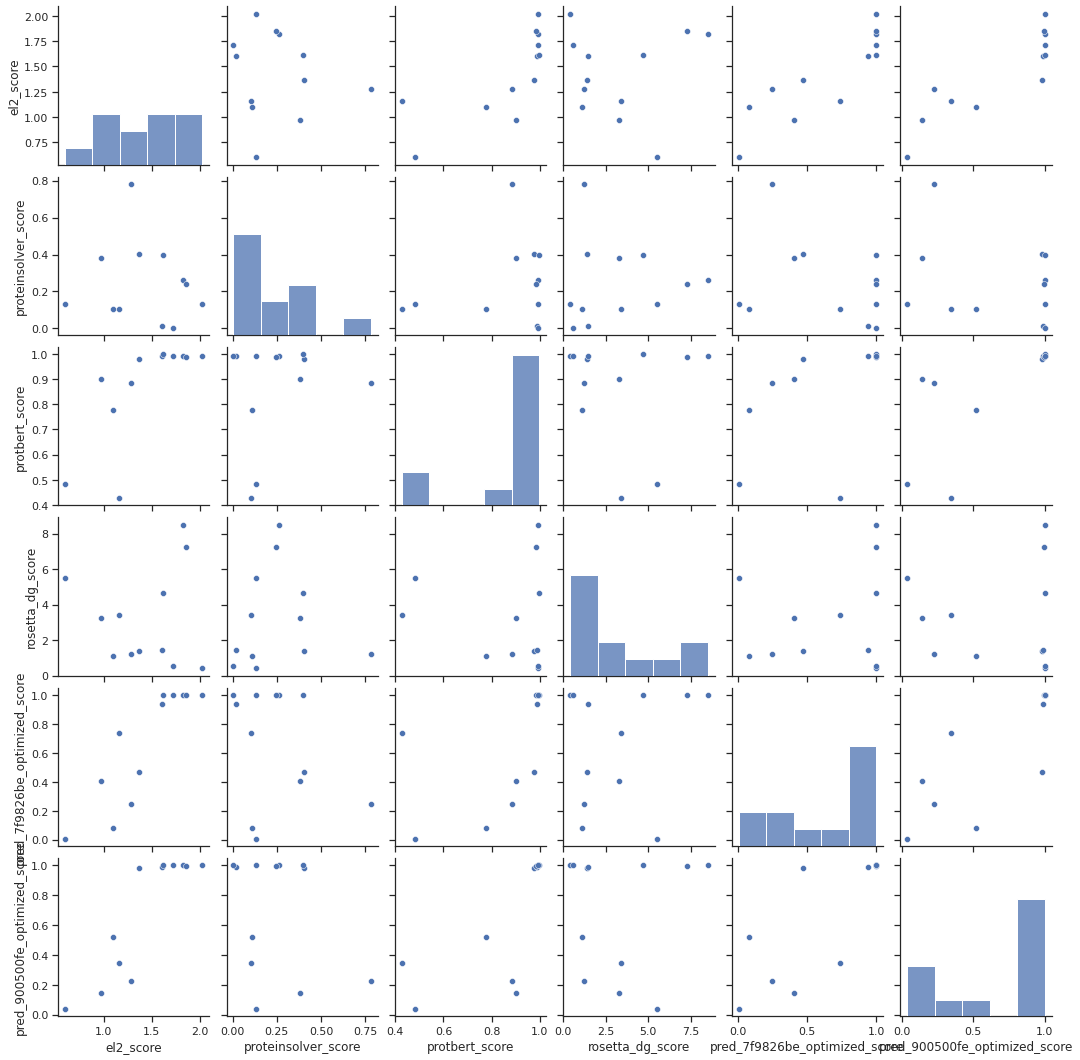

In [47]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(
    final_result_df[
        [
            "el2_score",
            "proteinsolver_score",
            "protbert_score",
            "rosetta_dg_score",
            "pred_7f9826be_optimized_score",
            "pred_900500fe_optimized_score",
        ]
    ]
)

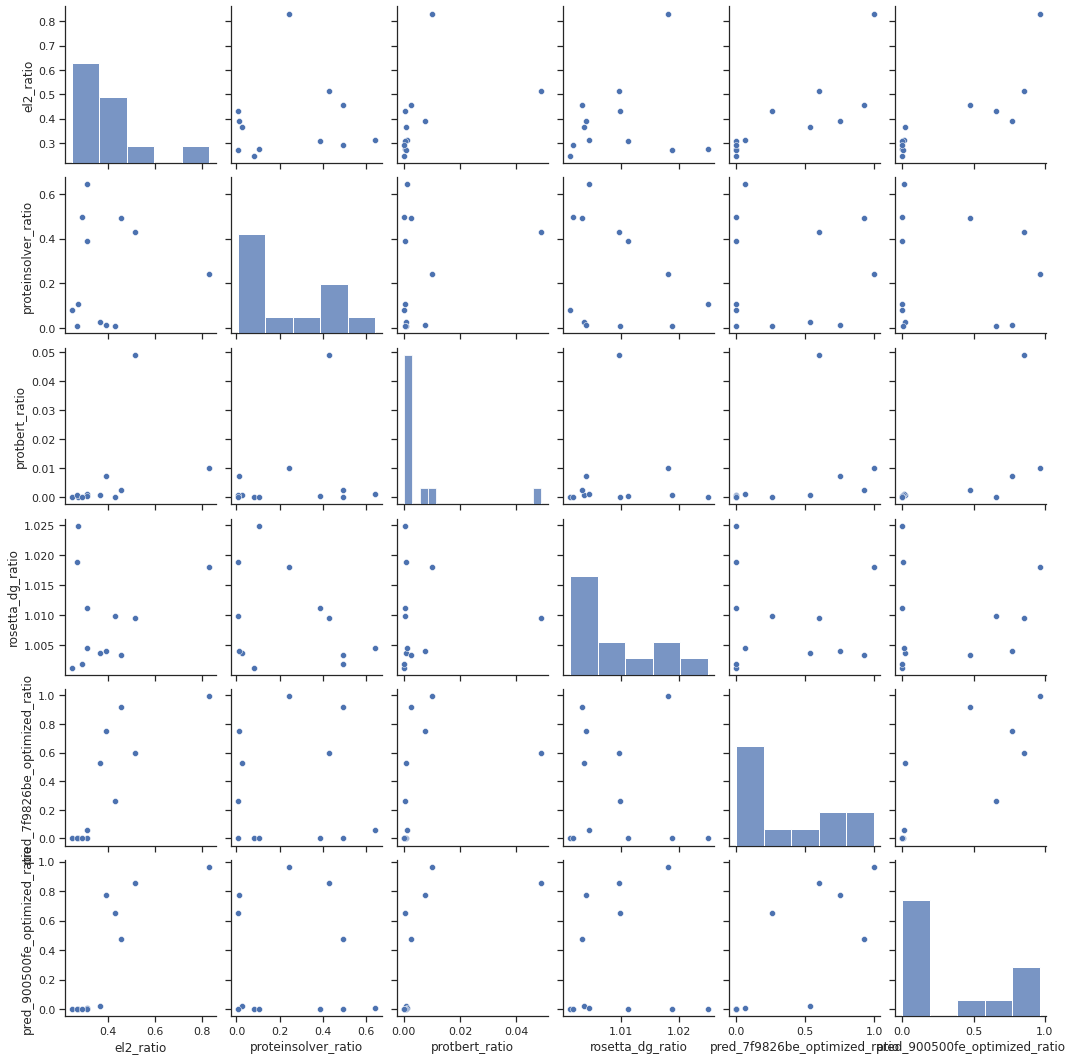

In [48]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(
    final_result_df[
        [
            "el2_ratio",
            "proteinsolver_ratio",
            "protbert_ratio",
            "rosetta_dg_ratio",
            "pred_7f9826be_optimized_ratio",
            "pred_900500fe_optimized_ratio",
        ]
    ]
)

## Write results

In [49]:
output_dir = NOTEBOOK_DIR.joinpath("submission")
output_dir.mkdir(exist_ok=True)

output_dir

PosixPath('/home/kimlab5/strokach/workspace/elaspic/elaspic2-cagi6/notebooks/40_cagi6_mapk3_submission/submission')

In [50]:
%%file {output_dir}/strokach_desc.md
# Submission for CAGI6—MAPK3 challenge

## Overview

- `strokach_modelnumber_1.tsv` → Predictions made using ELASPIC2 [1].
- `strokach_modelnumber_2.tsv` → Predictions made using ProteinSolver [2].
- `strokach_modelnumber_3.tsv` → Predictions made using ProtBert [3].
- `strokach_modelnumber_4.tsv` → Predictions made using Rosetta's cartesian_ddg protocol [4].
- `strokach_modelnumber_5.tsv` → Predictions made using ELASPIC2 with AlphaFold [5] features for wildtype protein.
- `strokach_modelnumber_6.tsv` → Predictions made using ELASPIC2 with AlphaFold [5] features for wildtype and mutant proteins.

## References

- [1] Strokach et al. (2021). _ELASPIC2 (EL2): Combining Contextualized Language Models and Graph Neural Networks to Predict Effects of Mutations._ https://doi.org/10.1016/j.jmb.2021.166810
- [2] Strokach et al. (2020). _Fast and Flexible Protein Design Using Deep Graph Neural Networks._ https://doi.org/10.1016/j.cels.2020.08.016
- [3] Elnaggar et al. (2020). _ProtTrans: Towards Cracking the Language of Life’s Code Through Self-Supervised Deep Learning and High Performance Computing._ https://doi.org/10.1101/2020.07.12.199554
- [4] Park et al. (2016). _Simultaneous Optimization of Biomolecular Energy Functions on Features from Small Molecules and Macromolecules._ https://doi.org/10.1021/acs.jctc.6b00819
- [5] Jumper et al. (2021). _Highly accurate protein structure prediction with AlphaFold._ https://doi.org/10.1038/s41586-021-03819-2

Overwriting /home/kimlab5/strokach/workspace/elaspic/elaspic2-cagi6/notebooks/40_cagi6_mapk3_submission/submission/strokach_desc.md


In [51]:
result_dfs = {}
for i, metric in enumerate(
    [
        "el2",
        "proteinsolver",
        "protbert",
        "rosetta_dg",
        "pred_7f9826be_optimized",
        "pred_900500fe_optimized",
    ]
):
    result_dfs[metric] = final_result_df.copy()
    result_dfs[metric]["DDG-NotPO4"] = -result_dfs[metric][f"{metric}_score"].values
    result_dfs[metric]["Standard-Deviation-DDG-NotPO4"] = 1.0
    result_dfs[metric]["DDG-PO4"] = -result_dfs[metric][f"{metric}_score"].values
    result_dfs[metric][" Standard-Deviation-DDG-PO4"] = 1.0
    result_dfs[metric]["Ratio-kcat/Km"] = result_dfs[metric][f"{metric}_ratio"].values
    result_dfs[metric]["Standard-Deviation-Ratio-kcat/Km"] = 1.0
    result_dfs[metric]["Comment"] = "*"

    print(metric)
    display(result_dfs[metric].head())

    output_file = output_dir.joinpath(f"strokach_modelnumber_{i + 1}.tsv")
    result_dfs[metric][result_template_df.columns].to_csv(output_file, sep="\t", index=False)
    !python {NOTEBOOK_DIR}/validation.py {output_file}

el2


,MAPK3-variant,DDG-NotPO4,Standard-Deviation-DDG-NotPO4,DDG-PO4,Standard-Deviation-DDG-PO4,Ratio-kcat/Km,Standard-Deviation-Ratio-kcat/Km,Comment,mut,protbert_score,...,el2_score,protbert_ratio,proteinsolver_ratio,el2_ratio,rosetta_dg_score,rosetta_dg_ratio,pred_7f9826be_optimized_score,pred_7f9826be_optimized_ratio,pred_900500fe_optimized_score,pred_900500fe_optimized_ratio
0,p.I73M,-1.363010,1.0,-1.363010,1.0,0.366835,1.0,*,I73M,0.977409,...,1.363010,0.000732,0.027899,0.366835,1.366667,1.003706,0.469003,0.530997,0.980679,1.932071e-02
1,p.Q79H,-1.607800,1.0,-1.607800,1.0,0.310984,1.0,*,Q79H,0.990033,...,1.607800,0.001132,0.644113,0.310984,1.452667,1.004529,0.938881,0.061119,0.990262,9.737610e-03
2,p.E98K,-2.022470,1.0,-2.022470,1.0,0.247222,1.0,*,E98K,0.990650,...,2.022470,0.000120,0.079353,0.247222,0.404000,1.001235,0.999945,0.000055,0.999547,4.531980e-04
3,p.A160T,-1.819285,1.0,-1.819285,1.0,0.274833,1.0,*,A160T,0.992665,...,1.819285,0.000308,0.106175,0.274833,8.508000,1.024971,0.999999,0.000001,1.000000,2.528369e-07
4,p.T198I,-1.847224,1.0,-1.847224,1.0,0.270676,1.0,*,T198I,0.985794,...,1.847224,0.000812,0.007174,0.270676,7.264333,1.018908,0.999825,0.000175,0.997698,2.301653e-03


The file's format is valid! You are good to submit now!
proteinsolver


,MAPK3-variant,DDG-NotPO4,Standard-Deviation-DDG-NotPO4,DDG-PO4,Standard-Deviation-DDG-PO4,Ratio-kcat/Km,Standard-Deviation-Ratio-kcat/Km,Comment,mut,protbert_score,...,el2_score,protbert_ratio,proteinsolver_ratio,el2_ratio,rosetta_dg_score,rosetta_dg_ratio,pred_7f9826be_optimized_score,pred_7f9826be_optimized_ratio,pred_900500fe_optimized_score,pred_900500fe_optimized_ratio
0,p.I73M,-0.405283,1.0,-0.405283,1.0,0.027899,1.0,*,I73M,0.977409,...,1.363010,0.000732,0.027899,0.366835,1.366667,1.003706,0.469003,0.530997,0.980679,1.932071e-02
1,p.Q79H,-0.015758,1.0,-0.015758,1.0,0.644113,1.0,*,Q79H,0.990033,...,1.607800,0.001132,0.644113,0.310984,1.452667,1.004529,0.938881,0.061119,0.990262,9.737610e-03
2,p.E98K,-0.130106,1.0,-0.130106,1.0,0.079353,1.0,*,E98K,0.990650,...,2.022470,0.000120,0.079353,0.247222,0.404000,1.001235,0.999945,0.000055,0.999547,4.531980e-04
3,p.A160T,-0.263915,1.0,-0.263915,1.0,0.106175,1.0,*,A160T,0.992665,...,1.819285,0.000308,0.106175,0.274833,8.508000,1.024971,0.999999,0.000001,1.000000,2.528369e-07
4,p.T198I,-0.243023,1.0,-0.243023,1.0,0.007174,1.0,*,T198I,0.985794,...,1.847224,0.000812,0.007174,0.270676,7.264333,1.018908,0.999825,0.000175,0.997698,2.301653e-03


The file's format is valid! You are good to submit now!
protbert


,MAPK3-variant,DDG-NotPO4,Standard-Deviation-DDG-NotPO4,DDG-PO4,Standard-Deviation-DDG-PO4,Ratio-kcat/Km,Standard-Deviation-Ratio-kcat/Km,Comment,mut,protbert_score,...,el2_score,protbert_ratio,proteinsolver_ratio,el2_ratio,rosetta_dg_score,rosetta_dg_ratio,pred_7f9826be_optimized_score,pred_7f9826be_optimized_ratio,pred_900500fe_optimized_score,pred_900500fe_optimized_ratio
0,p.I73M,-0.977409,1.0,-0.977409,1.0,0.000732,1.0,*,I73M,0.977409,...,1.363010,0.000732,0.027899,0.366835,1.366667,1.003706,0.469003,0.530997,0.980679,1.932071e-02
1,p.Q79H,-0.990033,1.0,-0.990033,1.0,0.001132,1.0,*,Q79H,0.990033,...,1.607800,0.001132,0.644113,0.310984,1.452667,1.004529,0.938881,0.061119,0.990262,9.737610e-03
2,p.E98K,-0.990650,1.0,-0.990650,1.0,0.000120,1.0,*,E98K,0.990650,...,2.022470,0.000120,0.079353,0.247222,0.404000,1.001235,0.999945,0.000055,0.999547,4.531980e-04
3,p.A160T,-0.992665,1.0,-0.992665,1.0,0.000308,1.0,*,A160T,0.992665,...,1.819285,0.000308,0.106175,0.274833,8.508000,1.024971,0.999999,0.000001,1.000000,2.528369e-07
4,p.T198I,-0.985794,1.0,-0.985794,1.0,0.000812,1.0,*,T198I,0.985794,...,1.847224,0.000812,0.007174,0.270676,7.264333,1.018908,0.999825,0.000175,0.997698,2.301653e-03


The file's format is valid! You are good to submit now!
rosetta_dg


,MAPK3-variant,DDG-NotPO4,Standard-Deviation-DDG-NotPO4,DDG-PO4,Standard-Deviation-DDG-PO4,Ratio-kcat/Km,Standard-Deviation-Ratio-kcat/Km,Comment,mut,protbert_score,...,el2_score,protbert_ratio,proteinsolver_ratio,el2_ratio,rosetta_dg_score,rosetta_dg_ratio,pred_7f9826be_optimized_score,pred_7f9826be_optimized_ratio,pred_900500fe_optimized_score,pred_900500fe_optimized_ratio
0,p.I73M,-1.366667,1.0,-1.366667,1.0,1.003706,1.0,*,I73M,0.977409,...,1.363010,0.000732,0.027899,0.366835,1.366667,1.003706,0.469003,0.530997,0.980679,1.932071e-02
1,p.Q79H,-1.452667,1.0,-1.452667,1.0,1.004529,1.0,*,Q79H,0.990033,...,1.607800,0.001132,0.644113,0.310984,1.452667,1.004529,0.938881,0.061119,0.990262,9.737610e-03
2,p.E98K,-0.404000,1.0,-0.404000,1.0,1.001235,1.0,*,E98K,0.990650,...,2.022470,0.000120,0.079353,0.247222,0.404000,1.001235,0.999945,0.000055,0.999547,4.531980e-04
3,p.A160T,-8.508000,1.0,-8.508000,1.0,1.024971,1.0,*,A160T,0.992665,...,1.819285,0.000308,0.106175,0.274833,8.508000,1.024971,0.999999,0.000001,1.000000,2.528369e-07
4,p.T198I,-7.264333,1.0,-7.264333,1.0,1.018908,1.0,*,T198I,0.985794,...,1.847224,0.000812,0.007174,0.270676,7.264333,1.018908,0.999825,0.000175,0.997698,2.301653e-03


The file's format is valid! You are good to submit now!
pred_7f9826be_optimized


,MAPK3-variant,DDG-NotPO4,Standard-Deviation-DDG-NotPO4,DDG-PO4,Standard-Deviation-DDG-PO4,Ratio-kcat/Km,Standard-Deviation-Ratio-kcat/Km,Comment,mut,protbert_score,...,el2_score,protbert_ratio,proteinsolver_ratio,el2_ratio,rosetta_dg_score,rosetta_dg_ratio,pred_7f9826be_optimized_score,pred_7f9826be_optimized_ratio,pred_900500fe_optimized_score,pred_900500fe_optimized_ratio
0,p.I73M,-0.469003,1.0,-0.469003,1.0,0.530997,1.0,*,I73M,0.977409,...,1.363010,0.000732,0.027899,0.366835,1.366667,1.003706,0.469003,0.530997,0.980679,1.932071e-02
1,p.Q79H,-0.938881,1.0,-0.938881,1.0,0.061119,1.0,*,Q79H,0.990033,...,1.607800,0.001132,0.644113,0.310984,1.452667,1.004529,0.938881,0.061119,0.990262,9.737610e-03
2,p.E98K,-0.999945,1.0,-0.999945,1.0,0.000055,1.0,*,E98K,0.990650,...,2.022470,0.000120,0.079353,0.247222,0.404000,1.001235,0.999945,0.000055,0.999547,4.531980e-04
3,p.A160T,-0.999999,1.0,-0.999999,1.0,0.000001,1.0,*,A160T,0.992665,...,1.819285,0.000308,0.106175,0.274833,8.508000,1.024971,0.999999,0.000001,1.000000,2.528369e-07
4,p.T198I,-0.999825,1.0,-0.999825,1.0,0.000175,1.0,*,T198I,0.985794,...,1.847224,0.000812,0.007174,0.270676,7.264333,1.018908,0.999825,0.000175,0.997698,2.301653e-03


The file's format is valid! You are good to submit now!
pred_900500fe_optimized


,MAPK3-variant,DDG-NotPO4,Standard-Deviation-DDG-NotPO4,DDG-PO4,Standard-Deviation-DDG-PO4,Ratio-kcat/Km,Standard-Deviation-Ratio-kcat/Km,Comment,mut,protbert_score,...,el2_score,protbert_ratio,proteinsolver_ratio,el2_ratio,rosetta_dg_score,rosetta_dg_ratio,pred_7f9826be_optimized_score,pred_7f9826be_optimized_ratio,pred_900500fe_optimized_score,pred_900500fe_optimized_ratio
0,p.I73M,-0.980679,1.0,-0.980679,1.0,1.932071e-02,1.0,*,I73M,0.977409,...,1.363010,0.000732,0.027899,0.366835,1.366667,1.003706,0.469003,0.530997,0.980679,1.932071e-02
1,p.Q79H,-0.990262,1.0,-0.990262,1.0,9.737610e-03,1.0,*,Q79H,0.990033,...,1.607800,0.001132,0.644113,0.310984,1.452667,1.004529,0.938881,0.061119,0.990262,9.737610e-03
2,p.E98K,-0.999547,1.0,-0.999547,1.0,4.531980e-04,1.0,*,E98K,0.990650,...,2.022470,0.000120,0.079353,0.247222,0.404000,1.001235,0.999945,0.000055,0.999547,4.531980e-04
3,p.A160T,-1.000000,1.0,-1.000000,1.0,2.528369e-07,1.0,*,A160T,0.992665,...,1.819285,0.000308,0.106175,0.274833,8.508000,1.024971,0.999999,0.000001,1.000000,2.528369e-07
4,p.T198I,-0.997698,1.0,-0.997698,1.0,2.301653e-03,1.0,*,T198I,0.985794,...,1.847224,0.000812,0.007174,0.270676,7.264333,1.018908,0.999825,0.000175,0.997698,2.301653e-03


The file's format is valid! You are good to submit now!
